# Import packages

Due to the setting of different environment, the installing method of packages is different.


If the system is windows, open the command prompt and type:


"pip install category_encoders


pip install nltk"
(If the system is equipped with pip).


Or, open the anaconda prompt and type:


"conda install -c conda-forge category_encoders 


conda install -c anaconda nltk "
(If the system is equipped with anaconda).

In [29]:
# For the system of Linux
! pip install --user category_encoders
! pip install --user nltk

In [ ]:
# For the system of Mac
! pip install category_encoders
! pip install nltk

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn import preprocessing, metrics
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import matplotlib
import matplotlib.pyplot as plt
import nltk.stem
from datetime import datetime as dt
#np.set_printoptions(threshold=np.nan)

/Users/zengweihao/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


Load the dataset.

In [2]:
train = pd.read_csv('ADAS_File_5_updated.csv',encoding='latin-1',error_bad_lines=False)

The address for the test dataset is:
https://drive.google.com/file/d/1Bb6HTosGaFx_PxWkHdwiMndt0UGL8nqi/view?usp=sharing

In [3]:
test=pd.read_csv('data_unlabelled_xing.csv',encoding='latin-1',error_bad_lines=False)
test=test[test['batch']==2]
test = test.loc[(test['FAILDATE'] >= 20120101) & (test['FAILDATE'] <= 20190000)]

/Users/zengweihao/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning:

Columns (28,36,44) have mixed types. Specify dtype option on import or set low_memory=False.



Check the size of data

In [4]:
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)
print("data size is : {}".format(data.shape))

/Users/zengweihao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




data size is : (157602, 70)


In [5]:
train.shape

(2496, 59)

In [6]:
test.shape

(155106, 60)

In [7]:
data.shape

(157602, 70)

Extract different target variables from the dataset to fit different models.

In [8]:
adas1=train['ADAS1']
aeb1=train['AutomaticEmergencyBraking1']
acc1=train['AdaptiveCruiseControl1']

We would like build some features based on the existing variables.

In [9]:
#The Age of car
data['FAILDATE'] = pd.to_datetime(data['FAILDATE'], format = "%Y%m%d")
data['AGE'] = data['FAILDATE'].apply(lambda x: int(str(x)[:4])) - data['YEARTXT']
data['AGE'] = data['AGE'].apply(lambda x: 0 if x < 0 else x)

#The full name of model
data['MODEL_YEAR'] = data['MFR_NAME'] + data['MAKETXT'] + data['YEARTXT'].apply(lambda x : str(x))

data['MFR_NAME'] = data['MFR_NAME'] + data['MAKETXT']

## Same model name can be used in different makes
data['MODELTXT']=data["MAKETXT"].map(str) +' '+ data["MODELTXT"]

#To distinguish different cities with same name
data['CITY'] = data['CITY'] + data['STATE']

#The month(the influence of season etc.) and the day(work day or weekend) of faildate.
data['FAILDATE'] = pd.to_datetime(data['FAILDATE'], format = "%Y%m%d")
data['FAILMONTH'] = data['FAILDATE'].apply(lambda x : x.month)
data['FAILWEEKDAY'] = data['FAILDATE'].dt.dayofweek

Not all the variables are needed in the model, so they will be dropped.

In [10]:
cols_use = ['MFR_NAME', 'MAKETXT','MODELTXT','MODEL_YEAR', 'YEARTXT', 'CRASH', 'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE', 'MILES',
            'OCCURENCES', 'CDESCR', 'ANTI_BRAKES_YN', 'CRUISE_CONT_YN', 'VEH_SPEED', 'AGE', 'FAILMONTH', 'FAILWEEKDAY']

data = data[cols_use]

To lower the font in the complaint and description of components.

In [11]:
data["CDESCR"] = data["CDESCR"].apply(lambda x : str(x).lower())
data["COMPDESC"] = data["COMPDESC"].apply(lambda x : x.lower())

# Combine the brand and the car type to make sure the type is unique
- We find that since different car brands may have the same name of their car types, we cannot uniquely identify the model of the car without combineing the car's brand and the car's model. Therefore, we combine the brand (`MAKETXT`) and the car type (`MODELTXT`) to make sure the car's model is unique

# Brief description about the numeric variable
- After looking carefully of the numeric variable, we think that in the true dataset, there may be outliers at `INJURED` (number of people injured in the accident), `DEATHS` (number of people dead in the accident), `OCCURENCES` (number of the mulfunction condition occured), `VEH_SPEED` (the speed of the car when the accident happened). 

In [12]:
data.describe()
### outlier in INJURED, DEATHS, OCCURENCES(number of occurence), VEH_SPEED

,YEARTXT,INJURED,DEATHS,MILES,OCCURENCES,VEH_SPEED,AGE,FAILMONTH,FAILWEEKDAY
count,157602.000000,56182.000000,53547.000000,1.291350e+05,43247.000000,104146.000000,157602.000000,157602.000000,157602.000000
mean,2013.748493,0.183404,0.008927,3.483297e+04,1.190348,30.761642,1.958091,6.379170,2.667942
std,1.559546,0.735022,0.494464,8.532986e+04,1.220660,29.439233,1.715441,3.321202,1.918884
min,2012.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2012.000000,0.000000,0.000000,5.000000e+03,1.000000,5.000000,0.000000,4.000000,1.000000
50%,2013.000000,0.000000,0.000000,2.300000e+04,1.000000,30.000000,2.000000,6.000000,3.000000
75%,2015.000000,0.000000,0.000000,5.162800e+04,1.000000,55.000000,3.000000,9.000000,4.000000
max,2018.000000,99.000000,99.000000,9.000443e+06,100.000000,999.000000,6.000000,12.000000,6.000000


In [13]:
data.head()

,MFR_NAME,MAKETXT,MODELTXT,MODEL_YEAR,YEARTXT,CRASH,FIRE,INJURED,DEATHS,COMPDESC,...,STATE,MILES,OCCURENCES,CDESCR,ANTI_BRAKES_YN,CRUISE_CONT_YN,VEH_SPEED,AGE,FAILMONTH,FAILWEEKDAY
0,Chrysler (FCA US LLC)CHRYSLER,CHRYSLER,CHRYSLER 200,Chrysler (FCA US LLC)CHRYSLER2015,2015,Y,N,1.0,0.0,seat belts,...,SC,78000.0,1.0,tl* the contact owned a 2015 chrysler 200. the...,N,N,60.0,2,9,1
1,Hyundai Motor AmericaHYUNDAI,HYUNDAI,HYUNDAI SANTA FE,Hyundai Motor AmericaHYUNDAI2015,2015,N,N,NaN,NaN,electrical system,...,IN,21500.0,1.0,similar to incident 10885095; blind spot detec...,N,N,70.0,1,11,3
2,Toyota Motor CorporationTOYOTA,TOYOTA,TOYOTA LAND CRUISER,Toyota Motor CorporationTOYOTA2016,2016,N,N,NaN,NaN,electrical system,...,CA,6000.0,NaN,purchased vehicle in early 2016. may/june 201...,N,N,0.0,1,3,0
3,"Tesla Motors, Inc.TESLA",TESLA,TESLA MODEL S,"Tesla Motors, Inc.TESLA2016",2016,N,N,NaN,NaN,suspension,...,CA,7000.0,NaN,here is a tesla in the salvage yard. https://...,N,N,30.0,0,11,1
4,Ford Motor CompanyFORD,FORD,FORD ESCAPE,Ford Motor CompanyFORD2014,2014,N,Y,NaN,NaN,unknown or other,...,PA,58205.0,NaN,driving down the road (4 lane highway) and my ...,N,N,70.0,3,1,0


In [14]:
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [15]:
# another split method: base on time series, we use the preivious data to predict the future data

#cv=TimeSeriesSplit(n_splits=5)    
#data=data.sort_values(by=['DATEA'])
#data['DATEA'].head()

# Handle outliers
- For `INJURED` and `DEATHS`, a maximum accomdation for a car/minivan is 8 people. If the number of injured or dead people is over 10, we adjust it to 8.

- For the `OCCURENCES`, our boundary is qualtile 95th. If the number of occurence is over the number at 95th qualtile, we adjust it to the number at 95th qualtile.

- For the `VEH_SPEED`, if the speed of the car exceed 160 km/h, we adjust it to 160.

In [16]:
data["INJURED"]=data["INJURED"].clip(upper=8)

In [17]:
data["DEATHS"]=data["DEATHS"].clip(upper=8)

In [18]:
data["OCCURENCES"]=data["OCCURENCES"].clip(upper=data["OCCURENCES"].quantile(q=0.95))

In [19]:
data["VEH_SPEED"]=data["VEH_SPEED"].clip(upper=160)
data["VEH_SPEED"]=data["VEH_SPEED"].clip(lower=0)

# Handle "NA"
- For `INJURED` and `DEATHS`, we use 0 to fill the null value.
- For `MILES` (the miles of the car), we fill the number that is the median of the `MILES` add a random number form the normal distribution ranged from 0 to 3000.
- For `OCCURENCES`, we use 1 to fill the null value.
- For `VEH_SPEED`, we fill the number that is the median of the `VEH_SPEED` add a random number form the normal distribution ranged from 0 to 200.
- For `MEDICAL_ATTN` (Was medical attention required) and `VEHICLES_TOWED_YN` (Was vehicle towed), since they are binary of "Y" (yes) and "N" (no), we decide to use "N" to fill the null value.

In [20]:
np.random.seed(1)

In [21]:
## fill na
data['INJURED'] = data['INJURED'].fillna(0)
data['DEATHS'] = data['DEATHS'].fillna(0)
data['MILES'] = data['MILES'].fillna(data[:ntrain]['MILES'].median())+np.random.normal(0,3000)
data['VEH_SPEED'] = data['VEH_SPEED'].fillna(data[:ntrain]['VEH_SPEED'].median()) + np.random.normal(0,5)
data['OCCURENCES'] = data['OCCURENCES'].fillna(1)
data['ANTI_BRAKES_YN'] = data['ANTI_BRAKES_YN'].fillna('N')
data['CRUISE_CONT_YN'] = data['CRUISE_CONT_YN'].fillna('N')

In [22]:
data.head()

,MFR_NAME,MAKETXT,MODELTXT,MODEL_YEAR,YEARTXT,CRASH,FIRE,INJURED,DEATHS,COMPDESC,...,STATE,MILES,OCCURENCES,CDESCR,ANTI_BRAKES_YN,CRUISE_CONT_YN,VEH_SPEED,AGE,FAILMONTH,FAILWEEKDAY
0,Chrysler (FCA US LLC)CHRYSLER,CHRYSLER,CHRYSLER 200,Chrysler (FCA US LLC)CHRYSLER2015,2015,Y,N,1.0,0.0,seat belts,...,SC,82873.036091,1.0,tl* the contact owned a 2015 chrysler 200. the...,N,N,56.941218,2,9,1
1,Hyundai Motor AmericaHYUNDAI,HYUNDAI,HYUNDAI SANTA FE,Hyundai Motor AmericaHYUNDAI2015,2015,N,N,0.0,0.0,electrical system,...,IN,26373.036091,1.0,similar to incident 10885095; blind spot detec...,N,N,66.941218,1,11,3
2,Toyota Motor CorporationTOYOTA,TOYOTA,TOYOTA LAND CRUISER,Toyota Motor CorporationTOYOTA2016,2016,N,N,0.0,0.0,electrical system,...,CA,10873.036091,1.0,purchased vehicle in early 2016. may/june 201...,N,N,-3.058782,1,3,0
3,"Tesla Motors, Inc.TESLA",TESLA,TESLA MODEL S,"Tesla Motors, Inc.TESLA2016",2016,N,N,0.0,0.0,suspension,...,CA,11873.036091,1.0,here is a tesla in the salvage yard. https://...,N,N,26.941218,0,11,1
4,Ford Motor CompanyFORD,FORD,FORD ESCAPE,Ford Motor CompanyFORD2014,2014,N,Y,0.0,0.0,unknown or other,...,PA,63078.036091,1.0,driving down the road (4 lane highway) and my ...,N,N,66.941218,3,1,0


In [24]:
label_feats=['YEARTXT','FAILMONTH','FAILWEEKDAY']
text_feat= ['CDESCR']
cat_feats = set(data.dtypes[data.dtypes == "object"].index) | set(label_feats) - set(text_feat)
num_feats = set(data.dtypes[data.dtypes != "object"].index) - set(label_feats)

In [25]:
#data.loc[:,list(num_feats)]=data.loc[:,list(num_feats)].astype('float64')

In [26]:
train = data[:ntrain]
test = data[ntrain:]

make sure all numeric variables are in the same scale

In [27]:
scaler = StandardScaler()

In [28]:
class FactorExtractor(TransformerMixin, BaseEstimator):
    """
    In: pd.DataFrame
        Column in that Frame
    Out: pd.Series
    
    In: pd.DataFrame
        list of Columns in that Frame
    Out: pd.DataFrame
    """

    def __init__(self, factor):
        self.factor = factor

    def transform(self, data):
        return data.loc[:,self.factor]

    def fit(self, *_):
        return self


In [30]:
import category_encoders as ce
encoder = ce.OneHotEncoder(cols = cat_feats,return_df=False,handle_unknown='ignore')

In [31]:
nmf = NMF(init='random', random_state=0)

In [32]:
# allow stemming in Sklearn TfidfVectorizer
en_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([en_stemmer.stem(w) for w in analyzer(doc)])

tfidf_vectorizer= StemmedTfidfVectorizer(analyzer="word", stop_words='english')

In [33]:
gbm = GradientBoostingClassifier(learning_rate=0.05)

In [34]:
catpipe=Pipeline([ ('cat_extractor',FactorExtractor(cat_feats)),
                   ('encode', encoder)
                  ])

numpipe=Pipeline([ ('feat_extractor',FactorExtractor(num_feats)),
                   #('Std',scaler)
                  ])

# extract the value in the list, so we can pass a pd series to the vectorizer, instead of a 1-column dataframe
textpipe=Pipeline([('text_extractor', FactorExtractor(text_feat[0])),  
                   ('tfidf',tfidf_vectorizer)#,
                   #('count',vectorizer)
                   #('nmf',nmf)
                  ])

feat_union=FeatureUnion([('text',textpipe),
                         ('num',numpipe),
                         ('cat',catpipe)
                        ])


pipe=Pipeline([ #('imputer',imp),
                ('union',feat_union),
                #('Std',scaler),
                ('clf',gbm)])

In [41]:
param_dist=dict(union__text__tfidf__max_df=[0.7,0.8,0.9],
                union__text__tfidf__min_df=range(1,15),
                union__text__tfidf__binary=[True,False],
                #union__text__nmf__n_components=range(5,20,2), 
                clf__loss=['deviance','exponential'],
                clf__n_estimators=[100,200],
                clf__subsample=[s/float(100) for s in range(50, 101, 2)],
                clf__max_features=[s/float(100) for s in range(1, 90, 3)],
                clf__max_depth=range(2,5),
                clf__min_samples_leaf=range(5,30,3),
                clf__min_samples_split=range(5,30),
                clf__random_state =range(1,10))

model=RandomizedSearchCV(pipe,param_dist,cv=cv,n_iter=30,random_state=1,scoring="roc_auc")


In [42]:
model.fit(train,adas1)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('text', Pipeline(memory=None,
     steps=[('text_extractor', FactorExtractor(factor='CDESCR')), ('tfidf', StemmedTfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
            dtype=<class 'numpy.float64'>, encod...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=30, n_jobs=None,
          param_distributions={'union__text__tfidf__max_df': [0.7, 0.8, 0.9], 'union__text__tfidf__min_df': range(1, 15), 'union__text__tfidf__binary': [True, False], 'clf__loss': ['deviance', 'exponential'], 'clf__n_estimators': [100, 200], 'clf__subsample': [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.6...s_leaf': range(5, 30, 3), 'clf__min_samples_spl

In [43]:
model.best_score_

0.9260055213677639

In [44]:
model.best_params_

{'clf__loss': 'deviance',
 'clf__max_depth': 3,
 'clf__max_features': 0.46,
 'clf__min_samples_leaf': 5,
 'clf__min_samples_split': 18,
 'clf__n_estimators': 200,
 'clf__random_state': 6,
 'clf__subsample': 0.68,
 'union__text__tfidf__binary': False,
 'union__text__tfidf__max_df': 0.8,
 'union__text__tfidf__min_df': 2}

In [45]:
# test set is too big, it raise error on prediction
test1=test[:20000]
test2=test[20000:40000]
test3=test[40000:60000]
test4=test[60000:80000]
test5=test[80000:100000]
test6=test[100000:120000]
test7=test[120000:140000]
test8=test[140000:]

In [46]:
prediction1=model.predict(test1)
prediction2=model.predict(test2)
prediction3=model.predict(test3)
prediction4=model.predict(test4)
prediction5=model.predict(test5)
prediction6=model.predict(test6)
prediction7=model.predict(test7)
prediction8=model.predict(test8)

In [47]:
prediction= np.concatenate((prediction1, prediction2,prediction3,prediction4,prediction5,prediction6,prediction7,prediction8), axis=None)
test['prediction'] = prediction

/Users/zengweihao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [48]:
test.to_csv('datasince2012_test_predicted.csv')

In [49]:
test_sample=test[test['prediction']==1].sample(n=100,random_state=0)

In [50]:
test_sample.to_csv('datasince2012_test_predicted_sample100.csv')

In [57]:
train['prediction'] = adas1.values

/Users/zengweihao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [62]:
alldata=pd.concat([train,test])
alldata.to_csv('datasince2012_all_labeled.csv')

In [66]:
test_sample.shape

(100, 22)

In [67]:
test.shape

(155106, 22)

In [65]:
alldata.shape

(157602, 22)

In [69]:
best_textpipe = model.best_estimator_.steps[0][1].transformer_list[0][1]
text_data = best_textpipe.transform(test).toarray()
text_cols = best_textpipe.steps[1][1].get_feature_names()
text_df = pd.DataFrame(data = text_data, columns = text_cols)

In [124]:
n_components = 5

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features ")
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = best_textpipe.steps[1][1].get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Fitting the NMF model (Frobenius norm) with tf-idf features 
done in 15.209s.

Topics in NMF model (Frobenius norm):
Topic #0: failur vehicl contact mileag tl own manufactur approxim diagnos repair notifi 000 taken state dealer warn mph 2012 illumin 2013
Topic #1: car drive engin problem start light time turn vehicl stop issu steer happen power brake acceler dealership mile transmiss park
Topic #2: contact repair part recal manufactur campaign nhtsa receiv number notif avail exceed unavail experienc reason state tl own confirm failur
Topic #3: door ajar close latch lock open driver light stay interior ford passeng unlock dome shut rear sensor handl remain batteri
Topic #4: airbag air bag seat passeng recal deploy takata belt driver crack light vehicl tire did crash injuri rear accid safeti



In [125]:
n_components = 15

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features ")
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = best_textpipe.steps[1][1].get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Fitting the NMF model (Frobenius norm) with tf-idf features 
done in 34.021s.

Topics in NMF model (Frobenius norm):
Topic #0: failur contact mileag vehicl tl own manufactur diagnos approxim notifi taken 000 repair dealer state 2012 illumin warn recur 2013
Topic #1: car start drive park turn stop happen hit tri pull time just got did road shut day went key abl
Topic #2: contact repair manufactur campaign part nhtsa number notif receiv exceed unavail experienc avail reason state tl own failur recal confirm
Topic #3: door ajar close latch lock open driver stay light interior unlock dome rear passeng shut sensor handl remain alarm insid
Topic #4: problem issu fix dealership time dealer told replac truck mile servic said new warranti took year safeti happen need month
Topic #5: steer power wheel turn drive assist lock difficult control right left lost loss make column speed highway fault rack tr
Topic #6: air bag deploy crash polic injuri file report sustain did medic attent contact requir

In [146]:
A = text_data

/Users/zengweihao/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:1192: MatplotlibDeprecationWarning:


Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.



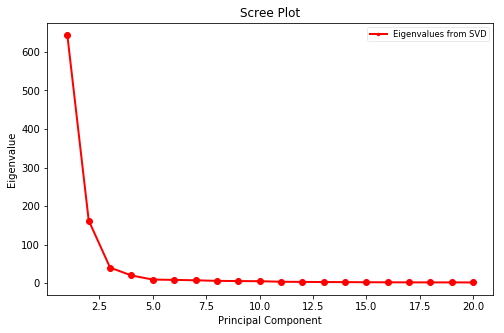

In [152]:
num_vars=A.shape[1]
A = np.asmatrix(A.T) * np.asmatrix(A)
U, S, V = np.linalg.svd(A) 
eigvals = S**2 / np.cumsum(S)[-1]
eigvals = eigvals[:20]
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(20) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()

In [ ]:
from __future__ import print_function
from time import time

n_components = 3
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


print("Loading dataset...")
t0 = time()
dataset = test
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
t0 = time()
tfidf = best_textpipe.transform(dataset)
print("done in %0.3fs." % (time() - t0))


In [169]:
n_components = 3

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features ")
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = best_textpipe.steps[1][1].get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features 
done in 16.710s.

Topics in NMF model (Frobenius norm):
Topic #0: failur vehicl contact mileag tl own manufactur approxim diagnos repair notifi 000 taken state dealer warn mph 2012 illumin 2013
Topic #1: car light drive problem vehicl time start engin turn issu stop happen steer brake power dealership tr mile recal park
Topic #2: contact recal part repair manufactur campaign nhtsa receiv number avail notif exceed unavail experienc reason state tl own confirm bag



In [170]:
n_components = 4

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features ")
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = best_textpipe.steps[1][1].get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features 
done in 12.193s.

Topics in NMF model (Frobenius norm):
Topic #0: failur vehicl contact mileag tl own manufactur approxim diagnos repair notifi 000 taken state dealer warn mph 2012 illumin 2013
Topic #1: car drive light problem vehicl engin start time turn issu stop steer happen brake power dealership acceler mile tr recal
Topic #2: contact recal part repair manufactur campaign nhtsa receiv number avail notif exceed unavail experienc reason state tl own confirm bag
Topic #3: door ajar close latch lock open driver light stay passeng interior ford unlock rear dome sensor shut seat handl remain



In [171]:
n_components = 5

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features ")
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = best_textpipe.steps[1][1].get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features 
done in 17.205s.

Topics in NMF model (Frobenius norm):
Topic #0: failur vehicl contact mileag tl own manufactur approxim diagnos repair notifi 000 taken state dealer warn mph 2012 illumin 2013
Topic #1: car drive engin problem start light time turn vehicl stop issu steer happen power brake acceler dealership mile transmiss park
Topic #2: contact repair part recal manufactur campaign nhtsa receiv number notif avail exceed unavail experienc reason state tl own confirm failur
Topic #3: door ajar close latch lock open driver light stay interior ford passeng unlock dome shut rear sensor handl remain batteri
Topic #4: airbag air bag seat passeng recal deploy takata belt driver crack light vehicl tire did crash injuri rear accid safeti



In [126]:
n_components = 6

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features ")
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = best_textpipe.steps[1][1].get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Fitting the NMF model (Frobenius norm) with tf-idf features 
done in 15.303s.

Topics in NMF model (Frobenius norm):
Topic #0: failur vehicl contact mileag tl own manufactur approxim diagnos repair notifi 000 taken state dealer mph warn 2012 illumin 2013
Topic #1: car engin start drive problem time light stop vehicl issu brake happen acceler transmiss dealership turn park mile tr dealer
Topic #2: contact repair part recal manufactur campaign nhtsa receiv number notif avail exceed unavail experienc reason state tl own confirm failur
Topic #3: door ajar close latch lock open driver light stay interior ford passeng unlock dome shut rear sensor handl remain batteri
Topic #4: airbag air bag seat passeng recal deploy takata belt driver crack light tire vehicl did crash injuri rear accid safeti
Topic #5: steer power wheel turn drive assist lock lost control difficult loss right left vehicl ford make warn highway road fault

